In [2]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Attempting uninstall: cellnet
    Found existing installation: cellnet 0.1.0
    Can't uninstall 'cellnet'. No files were found to uninstall.
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
from os.path import join

import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'
CKPT_PATH = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default/w_augment_4/checkpoints/val_f1_macro_epoch=45_val_f1_macro=0.847.ckpt'

In [3]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()
dataset_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/dataset_id.parquet'))
dataset = dd.read_parquet(join(DATA_PATH, 'test'), columns='dataset_id').compute().to_numpy()
tissue_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tissue_general.parquet'))
tissue = dd.read_parquet(join(DATA_PATH, 'test'), columns='tissue_general').compute().to_numpy()

# Load model & predict

In [4]:
estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=2048)
estim.model = TabnetClassifier.load_from_checkpoint(CKPT_PATH, **estim.get_fixed_model_params('tabnet'))
estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
# get feature embedding
estim.model.predict_bottleneck = True
x_emb = estim.predict(estim.datamodule.test_dataloader())
estim.model.predict_bottleneck = False

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 1684/1684 [05:43<00:00,  4.90it/s]


# Compute embeddings

## scTab

In [5]:
import matplotlib.pyplot as plt
import yaml

In [6]:
with open('shortend_cell_types.yaml', 'r') as f:
    shortend_cell_types = yaml.safe_load(f)

In [12]:
adata_emb = anndata.AnnData(
    X=x_emb, 
    obs=pd.DataFrame({
        'cell_type': cell_type_mapping.loc[cell_type].to_numpy().flatten(), 
        'dataset': dataset_mapping.loc[dataset].to_numpy().flatten(),
        'tissue': tissue_mapping.loc[tissue].to_numpy().flatten()
    })
)

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [23]:
adata_emb.obs['cell_type'] = adata_emb.obs['cell_type'].replace(shortend_cell_types)

In [13]:
# subset only to lung data
adata_emb = adata_emb[adata_emb.obs.tissue == 'lung']

In [15]:
sc.pp.pca(adata_emb, n_comps=50)
sc.pp.neighbors(adata_emb)
sc.tl.tsne(adata_emb)

In [25]:
adata_emb.write_h5ad('adatas/adata_lung_emb.h5ad')

## Raw features

In [28]:
from scipy.sparse import csr_matrix

In [29]:
def get_count_matrix_and_obs(ddf):
    x = (
        ddf['X']
        .map_partitions(
            lambda xx: pd.DataFrame(np.vstack(xx.tolist())), 
            meta={col: 'f4' for col in range(19331)}
        )
        .to_dask_array(lengths=[1024] * ddf.npartitions)
    )
    obs = ddf[['cell_type', 'tech_sample', 'assay', 'dataset_id', 'tissue_general', 'disease']].compute()
    
    return x, obs


In [30]:
ddf_test = dd.read_parquet(join(DATA_PATH, 'test'), split_row_groups=True)
x_test, obs_test = get_count_matrix_and_obs(ddf_test)

In [32]:
obs = pd.DataFrame({
    'cell_type': cell_type_mapping.loc[cell_type].to_numpy().flatten(), 
    'tissue': tissue_mapping.loc[tissue].to_numpy().flatten()
})

adata_lung_raw = anndata.AnnData(
    X=x_test[(obs.tissue == 'lung').to_numpy()].map_blocks(csr_matrix).compute(),
    obs=obs[obs.tissue == 'lung']
)

adata_lung_raw.obs['cell_type'] = adata_lung_raw.obs['cell_type'].replace(shortend_cell_types)

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [36]:
sc.pp.pca(adata_lung_raw, n_comps=50)
sc.pp.neighbors(adata_lung_raw)
sc.tl.tsne(adata_lung_raw)

In [37]:
adata_lung_raw.write_h5ad('adatas/adata_lung_raw.h5ad')

# Visualize embeddings

In [4]:
import matplotlib.pyplot as plt
import scanpy as sc

In [17]:
sc.settings.figdir = '/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/supp_figures/'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300 # If 'figure', uses the figure's dpi value.

In [5]:
plt.rcParams['figure.figsize'] = (5, 5)

In [6]:
adata_emb = anndata.read_h5ad('adatas/adata_lung_emb.h5ad')

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


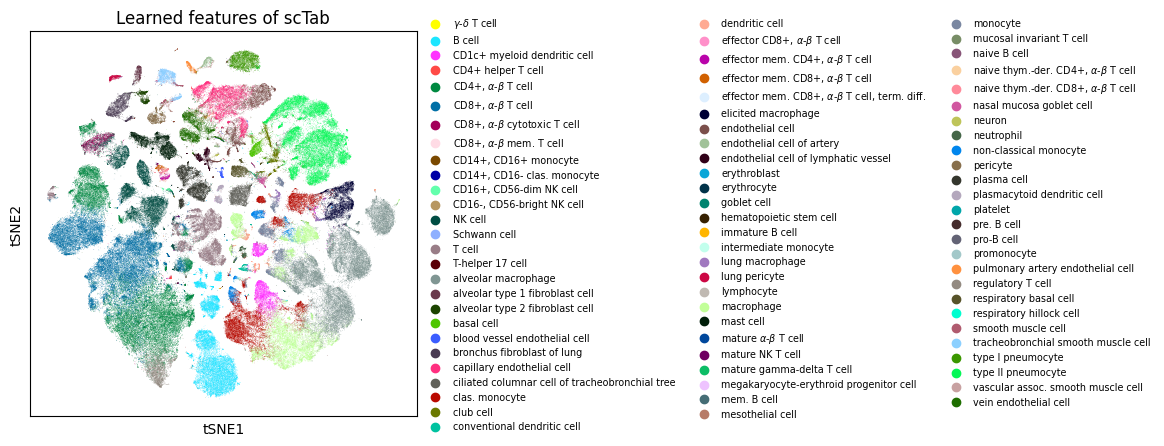

In [7]:
sc.pl.tsne(
    adata_emb, 
    color='cell_type', 
    legend_fontsize='x-small',
    title='Learned features of scTab',
    ncols=1,
    save='_learned_features.png'
)

In [8]:
adata_lung_raw = anndata.read_h5ad('adatas/adata_lung_raw.h5ad')

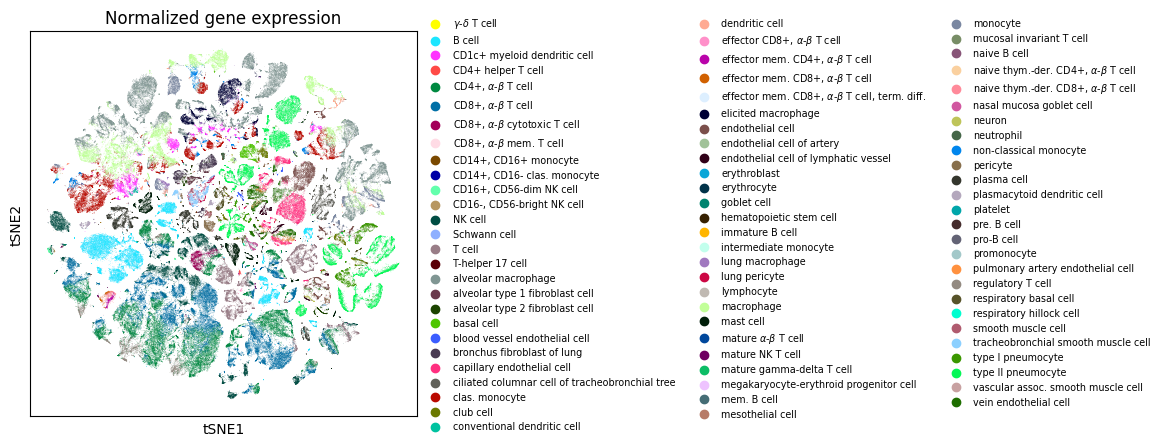

In [9]:
sc.pl.tsne(
    adata_lung_raw, 
    color='cell_type', 
    legend_fontsize='x-small',
    title='Normalized gene expression',
    ncols=1,
    save='_raw_features.png'
)